# DeepSearch Consistency and GO Coverage Analysis

This notebook summarizes run-to-run stability of DeepSearch gene programs and how those programs align with GO enrichment results provided in the `Comparisons/` folder.

In [14]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'geneset_folder_mapping.csv').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_DIR = PROJECT_ROOT / 'data'


## Run-to-run gene program consistency

In [15]:
matches = pd.read_csv(DATA_DIR / 'deepsearch_program_matches.csv')
runs = pd.read_csv(DATA_DIR / 'deepsearch_runs.csv')
unmatched_programs = pd.read_csv(DATA_DIR / 'deepsearch_unmatched_programs.csv')

match_summary = (
    matches.groupby(['metamodule', 'annotation', 'folder'])
    .agg(
        avg_similarity=('combined_similarity', 'mean'),
        median_similarity=('combined_similarity', 'median'),
        avg_gene_jaccard=('gene_jaccard', 'mean'),
        avg_name_similarity=('name_similarity', 'mean'),
        matched_pairs=('combined_similarity', 'size')
    )
    .reset_index()
)

run_counts = (
    runs.groupby(['metamodule', 'annotation', 'folder'])
    .agg(total_programs=('program_count', 'sum'))
    .reset_index()
)

unmatched_counts = (
    unmatched_programs.groupby(['metamodule', 'annotation', 'folder'])
    .size()
    .reset_index(name='unmatched_programs')
)

consistency = (
    match_summary
    .merge(run_counts, on=['metamodule', 'annotation', 'folder'])
    .merge(unmatched_counts, on=['metamodule', 'annotation', 'folder'])
)
consistency['matched_fraction'] = (consistency['matched_pairs'] * 2) / consistency['total_programs']
consistency['unmatched_fraction'] = consistency['unmatched_programs'] / consistency['total_programs']
consistency = consistency.sort_values('avg_similarity', ascending=False)
consistency


,metamodule,annotation,folder,avg_similarity,median_similarity,avg_gene_jaccard,avg_name_similarity,matched_pairs,total_programs,unmatched_programs,matched_fraction,unmatched_fraction
9,9,Proliferative 2,09_Proliferative_2,0.543254,0.523413,0.519841,0.566667,4,9,1,0.888889,0.111111
0,0,Gliosis,00_Gliosis,0.528247,0.444886,0.560065,0.496429,4,9,1,0.888889,0.111111
4,4,AC-gliosis-like 1,04_AC-gliosis-like_1,0.460967,0.534091,0.572727,0.349206,6,13,1,0.923077,0.076923
1,1,OPC-AC-like 1,01_OPC-AC-like_1,0.439815,0.361111,0.500000,0.379630,3,9,3,0.666667,0.333333
2,2,NPC-neuronal-like 1,02_NPC-neuronal-like_1,0.429684,0.419255,0.597464,0.261905,5,13,3,0.769231,0.230769
12,13,OPC-like 2,13_OPC-like_2,0.377671,0.395833,0.533120,0.222222,3,14,8,0.428571,0.571429
8,8,Gliosis-hypoxia,08_Gliosis-hypoxia,0.361888,0.265152,0.297850,0.425926,3,9,3,0.666667,0.333333
3,3,NPC-neuronal-like 2,03_NPC-neuronal-like_2,0.343056,0.312500,0.444444,0.241667,3,8,2,0.750000,0.250000
11,11,OPC-like 1,11_OPC-like_1,0.301557,0.335227,0.436448,0.166667,3,14,8,0.428571,0.571429
10,10,AC-gliosis-like 2,10_AC-gliosis-like_2,0.284732,0.310606,0.313908,0.255556,3,8,2,0.750000,0.250000


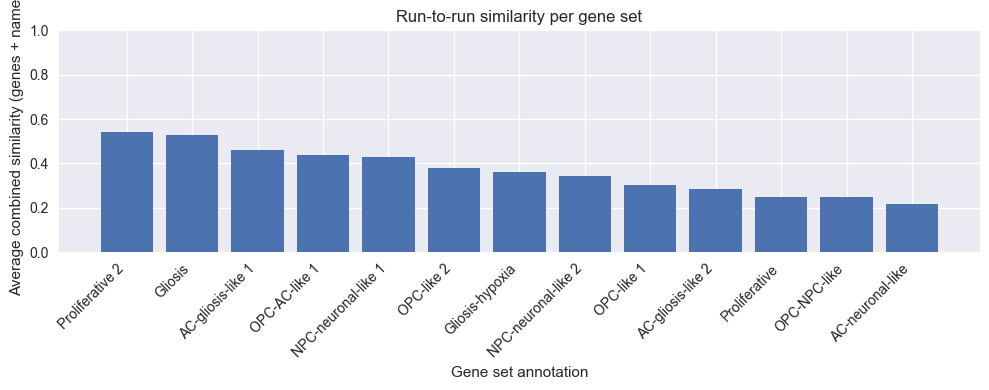

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(consistency['annotation'], consistency['avg_similarity'], color='#4C72B0')
ax.set_ylabel('Average combined similarity (genes + names)')
ax.set_xlabel('Gene set annotation')
ax.set_title('Run-to-run similarity per gene set')
ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Run-to-run similarity uses a weighted score (0.6 gene-set Jaccard + 0.4 text similarity). Even when similarity is high, unmatched program fractions highlight how stochasticity introduces novel programs per run.

## GO enrichment coverage from comparison reports

In [17]:
comparison_summary = pd.read_csv(DATA_DIR / 'comparison_summary.csv')
mapping = pd.read_csv(PROJECT_ROOT / 'geneset_folder_mapping.csv')
all_sets = mapping[['metamodule', 'annotation', 'new_folder']].rename(columns={'new_folder': 'folder'})
missing_sets = all_sets[~all_sets['metamodule'].isin(comparison_summary['metamodule'])]
comparison_summary['go_match_pct'] = comparison_summary['matched_go_terms_estimated'] / comparison_summary['total_gsea_terms'] * 100
comparison_summary['go_unmatched_pct'] = comparison_summary['unmatched_go_terms_reported'] / comparison_summary['total_gsea_terms'] * 100
comparison_summary = comparison_summary.sort_values('go_match_pct', ascending=False)
comparison_summary


,metamodule,annotation,folder,source_file,total_gsea_terms,unmatched_go_terms_reported,unmatched_go_terms_listed,matched_go_terms_estimated,programs_total,programs_without_go_match,go_match_pct,go_unmatched_pct
1,10,AC-gliosis-like 2,10_AC-gliosis-like_2,comparison geneset_11.md,25,0,0,25,5,0,100.0000,0.0000
2,12,NPC-neuronal-like 3,12_NPC-neuronal-like_3,comparison geneset_13.md,14,0,0,14,5,1,100.0000,0.0000
3,13,OPC-like 2,13_OPC-like_2,comparison geneset_14.md,22,0,0,22,12,5,100.0000,0.0000
4,1,OPC-AC-like 1,01_OPC-AC-like_1,comparison geneset_2.md,1,0,0,1,4,3,100.0000,0.0000
5,2,NPC-neuronal-like 1,02_NPC-neuronal-like_1,comparison geneset_3.md,15,0,0,15,9,6,100.0000,0.0000
6,3,NPC-neuronal-like 2,03_NPC-neuronal-like_2,comparison geneset_4.md,8,0,0,8,3,1,100.0000,0.0000
7,4,AC-gliosis-like 1,04_AC-gliosis-like_1,comparison geneset_5.md,11,0,0,11,7,4,100.0000,0.0000
8,5,AC-neuronal-like,05_AC-neuronal-like,comparison geneset_6.md,3,0,0,3,4,2,100.0000,0.0000
9,6,OPC-NPC-like,06_OPC-NPC-like,comparison geneset_7.md,24,0,0,24,5,4,100.0000,0.0000
10,7,Proliferative,07_Proliferative,comparison geneset_8.md,156,0,0,156,3,0,100.0000,0.0000


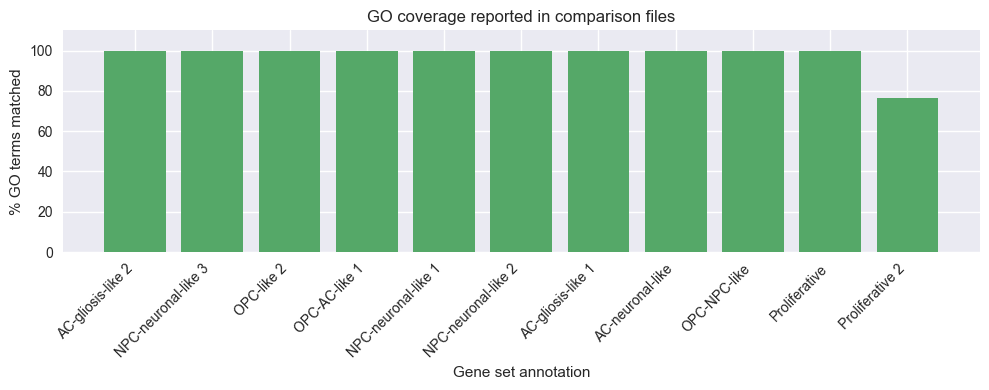

,metamodule,annotation,folder
0,0,Gliosis,00_Gliosis
8,8,Gliosis-hypoxia,08_Gliosis-hypoxia
11,11,OPC-like 1,11_OPC-like_1
14,14,OPC-AC-like 2,14_OPC-AC-like_2


In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(comparison_summary['annotation'], comparison_summary['go_match_pct'], color='#55A868')
ax.set_ylabel('% GO terms matched')
ax.set_xlabel('Gene set annotation')
ax.set_title('GO coverage reported in comparison files')
ax.set_ylim(0, 110)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if not missing_sets.empty:
    display(missing_sets)


Gene set `geneset_9` (metamodule 8) lacks a comparison table, so it is excluded from the coverage stats above.

## Novel gene programs without GO counterparts

In [19]:
novel_programs = pd.read_csv(DATA_DIR / 'comparison_novel_programs.csv')
program_catalog = pd.read_csv(DATA_DIR / 'deepsearch_programs.csv')
run1_catalog = program_catalog[program_catalog['run_index'] == 1][['folder', 'program_name', 'supporting_gene_count']]
novel_programs = novel_programs.merge(run1_catalog, on=['folder', 'program_name'], how='left', suffixes=('', '_run_data'))
novel_programs['supporting_gene_count'] = novel_programs['supporting_gene_count'].fillna(novel_programs['supporting_gene_count_run_data'])
novel_ranked = novel_programs.sort_values(['supporting_gene_count', 'annotation'], ascending=[False, True])
novel_ranked.head(20)


,metamodule,annotation,folder,source_file,program_name,supporting_gene_count,supporting_gene_count_run_data
1,13,OPC-like 2,13_OPC-like_2,comparison geneset_14.md,Lipid Metabolism and Membrane Remodeling,12.0,NaN
15,3,NPC-neuronal-like 2,03_NPC-neuronal-like_2,comparison geneset_4.md,Glioma Stem Cell Maintenance and Therapy Resis...,8.0,NaN
10,2,NPC-neuronal-like 1,02_NPC-neuronal-like_1,comparison geneset_3.md,Transcriptional Regulation and Chromatin Remod...,7.0,7.0
2,13,OPC-like 2,13_OPC-like_2,comparison geneset_14.md,Hypoxia Response and Angiogenic Signaling,7.0,NaN
20,5,AC-neuronal-like,05_AC-neuronal-like,comparison geneset_6.md,Glioblastoma Immune Suppression,6.0,6.0
4,13,OPC-like 2,13_OPC-like_2,comparison geneset_14.md,Amino Acid Metabolism and Nutrient Transport,6.0,NaN
16,4,AC-gliosis-like 1,04_AC-gliosis-like_1,comparison geneset_5.md,Angiogenesis and Vascular Remodeling,5.0,NaN
9,2,NPC-neuronal-like 1,02_NPC-neuronal-like_1,comparison geneset_3.md,GABAergic Neurotransmission,5.0,5.0
11,2,NPC-neuronal-like 1,02_NPC-neuronal-like_1,comparison geneset_3.md,cAMP Signaling and Kinase Cascades,4.0,4.0
22,6,OPC-NPC-like,06_OPC-NPC-like,comparison geneset_7.md,Sonic Hedgehog and GLI Signaling,4.0,4.0


The table ranks unmatched programs by the number of supporting genes reported in the DeepSearch output (run 1 for each gene set).

## Gene-set overlap heatmaps

Run-to-run gene overlap (Jaccard) matrices with overlap counts are saved to `analysis/confusion_heatmaps`.

In [20]:
from scripts.generate_heatmaps import Path as _Path
from scripts.generate_heatmaps import DATA_DIR as HEATMAP_DATA_DIR
print('Heatmaps saved to analysis/confusion_heatmaps. Rerun scripts/generate_heatmaps.py after installing matplotlib.')

ModuleNotFoundError: No module named 'scripts'

## Gene-set overlap heatmaps

The confusion matrices above are also available as color-coded heatmaps (Jaccard value + overlap/run gene counts) written to `analysis/confusion_heatmaps`.

In [21]:
# Generate heatmaps (requires matplotlib installed in the current kernel)
from scripts import generate_heatmaps
print(f'Heatmaps saved under {generate_heatmaps.OUTPUT_DIR}')

ModuleNotFoundError: No module named 'scripts'

In [ ]:
# Generate bubble visuals (requires matplotlib installed in the current kernel)
from scripts import generate_heatmaps
print(f'Bubble + key plots saved under {generate_heatmaps.OUTPUT_DIR}')